# German credit dataset

In [2]:
#Import library 
import pandas as pd
from IPython.display import Markdown, display
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
import seaborn as sns
import seaborn as sn

import seaborn; seaborn.set_style('whitegrid')
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import OrdinalEncoder

#from aif360.datasets import StandardDataset
#from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric

%matplotlib inline

from pomegranate import *
import pygraphviz
numpy.random.seed(0)
numpy.set_printoptions(suppress=True)
from sklearn.model_selection import train_test_split


In [3]:
#Read data
df=pd.read_csv("data/german_data_credit.csv")

# 1. Preliminary Data Analysis

## 1.1 Statistic information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   checking-account                       1000 non-null   object
 1   duration                               1000 non-null   int64 
 2   credit-history                         1000 non-null   object
 3   purpose                                1000 non-null   object
 4   credit-amount                          1000 non-null   int64 
 5   savings-account                        1000 non-null   object
 6   employment-since                       1000 non-null   object
 7   installment-rate                       1000 non-null   int64 
 8   other-debtors                          1000 non-null   object
 9   residence-since                        1000 non-null   int64 
 10  property                               1000 non-null   object
 11  age               

In [5]:
#for structuring only
Status_of_existing_checking_account={"no account": "A14","<0 DM": 'A11', "0 <= <200 DM": 'A12',">= 200 DM ": 'A13'}
df["checking-account"]=df["checking-account"].map(Status_of_existing_checking_account)

Credit_history={"critical account": "A34","delay in paying off": "A33","existing credits paid back duly till now": "A32","all credits at this bank paid back duly": "A31","no credits taken": "A30"}
df["credit-history"]=df["credit-history"].map(Credit_history)



Purpose={"car (new)": "A40", "car (used)": "A41", "furniture/equipment": "A42", "radio/television": "A43" , "domestic appliances": "A44",  "repairs": "A45", "education": "A46", 'vacation': 'A47', 'retraining': "A48",'business': "A49", 'others': "A410"}
df["purpose"]=df["purpose"].map(Purpose)

Saving_account={"no savings account": "A65","<100 DM": "A61","100 <= <500 DM": "A62","500 <= < 1000 DM": "A63", ">= 1000 DM": "A64"}
df["savings-account"]=df["savings-account"].map(Saving_account)

Present_employment={">=7 years": "A75", "4<= <7 years": "A74",  "1<= < 4 years": "A73", "<1 years": "A72","unemployed": "A71"}
df["employment-since"]=df["employment-since"].map(Present_employment)


#Personal_status_and_sex={ 'A95':"female:single",'A94':"male:married/widowed",'A93':"male:single", 'A92':"female:divorced/separated/married", 'A91':"male:divorced/separated"}
#df["personal-status-and-sex"]=df["personal-status-and-sex"].map(Personal_status_and_sex)

#sex={ 'A95':"female",'A94':"male",'A93':"male", 'A92':"female", 'A91':"male"}
# df["sex"]=['male' if (v=='A94' or v =='A93' or v == 'A91') else 'female' for v in df['personal-status-and-sex']]


Other_debtors_guarantors={"none":'A101', "co-applicant":'A102', "guarantor":'A103'}
df["other-debtors"]=df["other-debtors"].map(Other_debtors_guarantors)


Property={"real estate":'A121', "savings agreement/life insurance":'A122', "car or other":'A123', "unknown / no property":'A124'}
df["property"]=df["property"].map(Property)



Other_installment_plans={"none":'A143', "store":'A142', "bank":'A141'}
df["other-installment"]=df["other-installment"].map(Other_installment_plans)

Housing={"for free":'A153', "own":'A152', "rent":'A151'}
df["housing"]=df["housing"].map(Housing)



Job={"management/ highly qualified employee":'A174', "skilled employee / official":'A173', "unskilled - resident":'A172', "unemployed/ unskilled  - non-resident":'A171'}
df["job"]=df["job"].map(Job)

Telephone={"yes":'A192', "none":'A191'}
df["telephone"]=df["telephone"].map(Telephone)


foreign_worker={"yes":'A201', "no":'A202'}
df["foreign-worker"]=df["foreign-worker"].map(foreign_worker)

risk={1:"Good", 2:"Bad"}
df["class-label"]=df["class-label"].map(risk)
# df['class_label'] = [1 if v == 'Good' else 0 for v in df['risk']]
#Remove personal-status-and-sex
# df=df.drop(columns=['personal-status-and-sex'])


In [6]:
df.head(1)

,checking-account,duration,credit-history,purpose,credit-amount,savings-account,employment-since,installment-rate,other-debtors,residence-since,...,other-installment,housing,existing-credits,job,numner-people-provide-maintenance-for,telephone,foreign-worker,sex,marital-status,class-label
0,A11,6,A34,A43,1169,A65,A75,4,A101,4,...,A143,A152,2,A173,1,A192,A201,male,divorced/separated,Good


In [7]:
#df.to_csv("german_data_credit.csv",index=False) #save as csv file
#df=pd.read_csv("german_data_credit.csv",header=0) # read from csv

In [8]:
#statistical_parity
def statistical_parity_difference(dataset, protected,classes,majority_group,minority_group,positive_value):
    ratio = round(pd.crosstab(dataset[protected], dataset[classes]).div(pd.crosstab(dataset[protected], dataset[classes]).apply(sum,1),0),4)*100
    #return ratio
    return ratio.loc[majority_group][positive_value]-ratio.loc[minority_group][positive_value]

In [9]:
def basic_info(dataset,class_label,positive_value,negative_value,protected_attr,majority_group,minority_group):
    categorical_columns = (dataset.select_dtypes(['category', 'object']).columns)
    numeric_columns = (dataset.select_dtypes(['number']).columns)
    for attr in dataset.keys():
        if attr in categorical_columns:    
            print(attr ,' & Categorical & ',len(dataset[attr].value_counts()),'& &',dataset[attr].isnull().sum(),'\\\\')
        else:           
            print(attr,'& Numerical &',len(dataset[attr].value_counts()),'&',min(dataset[attr]),"-",max(dataset[attr]),'&',dataset[attr].isnull().sum(),'\\\\')  
    
    print('Class distribution:',dataset[class_label].value_counts())
    print('Class imbalance:',len(dataset.loc[dataset[class_label]==negative_value])/len(dataset.loc[dataset[class_label]==positive_value]))
    print('statistical parity:',statistical_parity_difference(dataset,protected_attr,class_label,majority_group,minority_group,positive_value))

In [10]:
basic_info(df,class_label="class-label",positive_value="Good",negative_value="Bad",
           protected_attr="sex",majority_group='male',minority_group='female')

checking-account  & Categorical &  4 & & 0 \\
duration & Numerical & 33 & 4 - 72 & 0 \\
credit-history  & Categorical &  5 & & 0 \\
purpose  & Categorical &  10 & & 0 \\
credit-amount & Numerical & 921 & 250 - 18424 & 0 \\
savings-account  & Categorical &  5 & & 0 \\
employment-since  & Categorical &  5 & & 0 \\
installment-rate & Numerical & 4 & 1 - 4 & 0 \\
other-debtors  & Categorical &  3 & & 0 \\
residence-since & Numerical & 4 & 1 - 4 & 0 \\
property  & Categorical &  4 & & 0 \\
age & Numerical & 53 & 19 - 75 & 0 \\
other-installment  & Categorical &  3 & & 0 \\
housing  & Categorical &  3 & & 0 \\
existing-credits & Numerical & 4 & 1 - 4 & 0 \\
job  & Categorical &  4 & & 0 \\
numner-people-provide-maintenance-for & Numerical & 2 & 1 - 2 & 0 \\
telephone  & Categorical &  2 & & 0 \\
foreign-worker  & Categorical &  2 & & 0 \\
sex  & Categorical &  2 & & 0 \\
marital-status  & Categorical &  2 & & 0 \\
class-label  & Categorical &  1 & & 300 \\
Class distribution: Good    700
Nam

In [11]:
df['foreign-worker'].value_counts()

A201    963
A202     37
Name: foreign-worker, dtype: int64

## 1.2 Missing value

In [12]:
#Check missing values
print('Missing values')
for i,j in zip(df.columns,(df.values.astype(str) == '?').sum(axis = 0)):
    if j > 0:
        print(str(i) + ': ' + str(j) + ' records')
print("---------------------------------")
df.isnull().sum()

Missing values
---------------------------------


checking-account                           0
duration                                   0
credit-history                             0
purpose                                    0
credit-amount                              0
savings-account                            0
employment-since                           0
installment-rate                           0
other-debtors                              0
residence-since                            0
property                                   0
age                                        0
other-installment                          0
housing                                    0
existing-credits                           0
job                                        0
numner-people-provide-maintenance-for      0
telephone                                  0
foreign-worker                             0
sex                                        0
marital-status                             0
class-label                              300
dtype: int

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 22 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   checking-account                       1000 non-null   object
 1   duration                               1000 non-null   int64 
 2   credit-history                         1000 non-null   object
 3   purpose                                1000 non-null   object
 4   credit-amount                          1000 non-null   int64 
 5   savings-account                        1000 non-null   object
 6   employment-since                       1000 non-null   object
 7   installment-rate                       1000 non-null   int64 
 8   other-debtors                          1000 non-null   object
 9   residence-since                        1000 non-null   int64 
 10  property                               1000 non-null   object
 11  age               

# 2. Bayesian network

In [18]:
X = df.values
for i in range(len(list(df.keys()))):
    print(i,list(df.keys())[i])
labels=list(df.keys())
# labels = list(map(str, range(len(list(df.keys())))))

0 checking-account
1 duration
2 credit-history
3 purpose
4 credit-amount
5 savings-account
6 employment-since
7 installment-rate
8 other-debtors
9 residence-since
10 property
11 age
12 other-installment
13 housing
14 existing-credits
15 job
16 numner-people-provide-maintenance-for
17 telephone
18 foreign-worker
19 sex
20 marital-status
21 class-label


In [19]:
#Encode
print(X[0])
X[:,1]=np.array([0 if v<=6 else 1 if v>6 and v<=12 else 2 for v in X[:,1]]) #duration
X[:,4]=np.array([0 if v<=2000 else 1 if v>2000 and v<=5000 else 2 for v in X[:,4]]) #credit amount
X[:,11]=np.array([0 if v<25 else 1 for v in X[:,11]]) #age
print(X[0])

['A11' 6 'A34' 'A43' 1169 'A65' 'A75' 4 'A101' 4 'A121' 67 'A143' 'A152' 2
 'A173' 1 'A192' 'A201' 'male' 'divorced/separated' 'Good']
['A11' 0 'A34' 'A43' 0 'A65' 'A75' 4 'A101' 4 'A121' 1 'A143' 'A152' 2
 'A173' 1 'A192' 'A201' 'male' 'divorced/separated' 'Good']


In [15]:
#Encode in dataframe
#duration
df['duration_enc'] = [0 if v<=6 else 1 if v>6 and v<=12 else 2 for v in df['duration']]
df['duration_enc']=df['duration_enc'].astype('category')
#credit amount
df['credit-amount_enc'] = ["<=2000 DM" if v<=2000 else "2000-5000 DM" if v>2000 and v<=5000 else ">5000 DM" for v in df['credit-amount']]
df['credit-amount_enc']=df['credit-amount_enc'].astype('category')
#age
df['age_enc'] = [0 if v<=25 else 1 for v in  df['age']]
df['age_enc']=df['age_enc'].astype('category')
df.head(1)

,checking-account,duration,credit-history,purpose,credit-amount,savings-account,employment-since,installment-rate,other-debtors,residence-since,...,job,numner-people-provide-maintenance-for,telephone,foreign-worker,sex,marital-status,class-label,duration_enc,credit-amount_enc,age_enc
0,A11,6,A34,A43,1169,A65,A75,4,A101,4,...,A173,1,A192,A201,male,divorced/separated,Good,0,<=2000 DM,1


In [16]:
print(df['age_enc'].value_counts())
print(df['age_enc'].value_counts()/len(df))

1    810
0    190
Name: age_enc, dtype: int64
1    0.81
0    0.19
Name: age_enc, dtype: float64


In [17]:
import networkx
from pomegranate.utils import plot_networkx
a = networkx.DiGraph()
b = tuple((0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20))
c= tuple((21,))
a.add_edge(b,c)
a.add_edge(b,b)
model = BayesianNetwork.from_samples(X, algorithm='exact',constraint_graph=a,state_names=labels)
print(model.structure)

((), (4, 7), (14,), (4,), (10,), (0,), (9,), (4,), (10,), (13,), (13,), (13,), (2,), (), (11,), (6,), (19, 20), (15,), (1,), (11, 20), (4,), ())


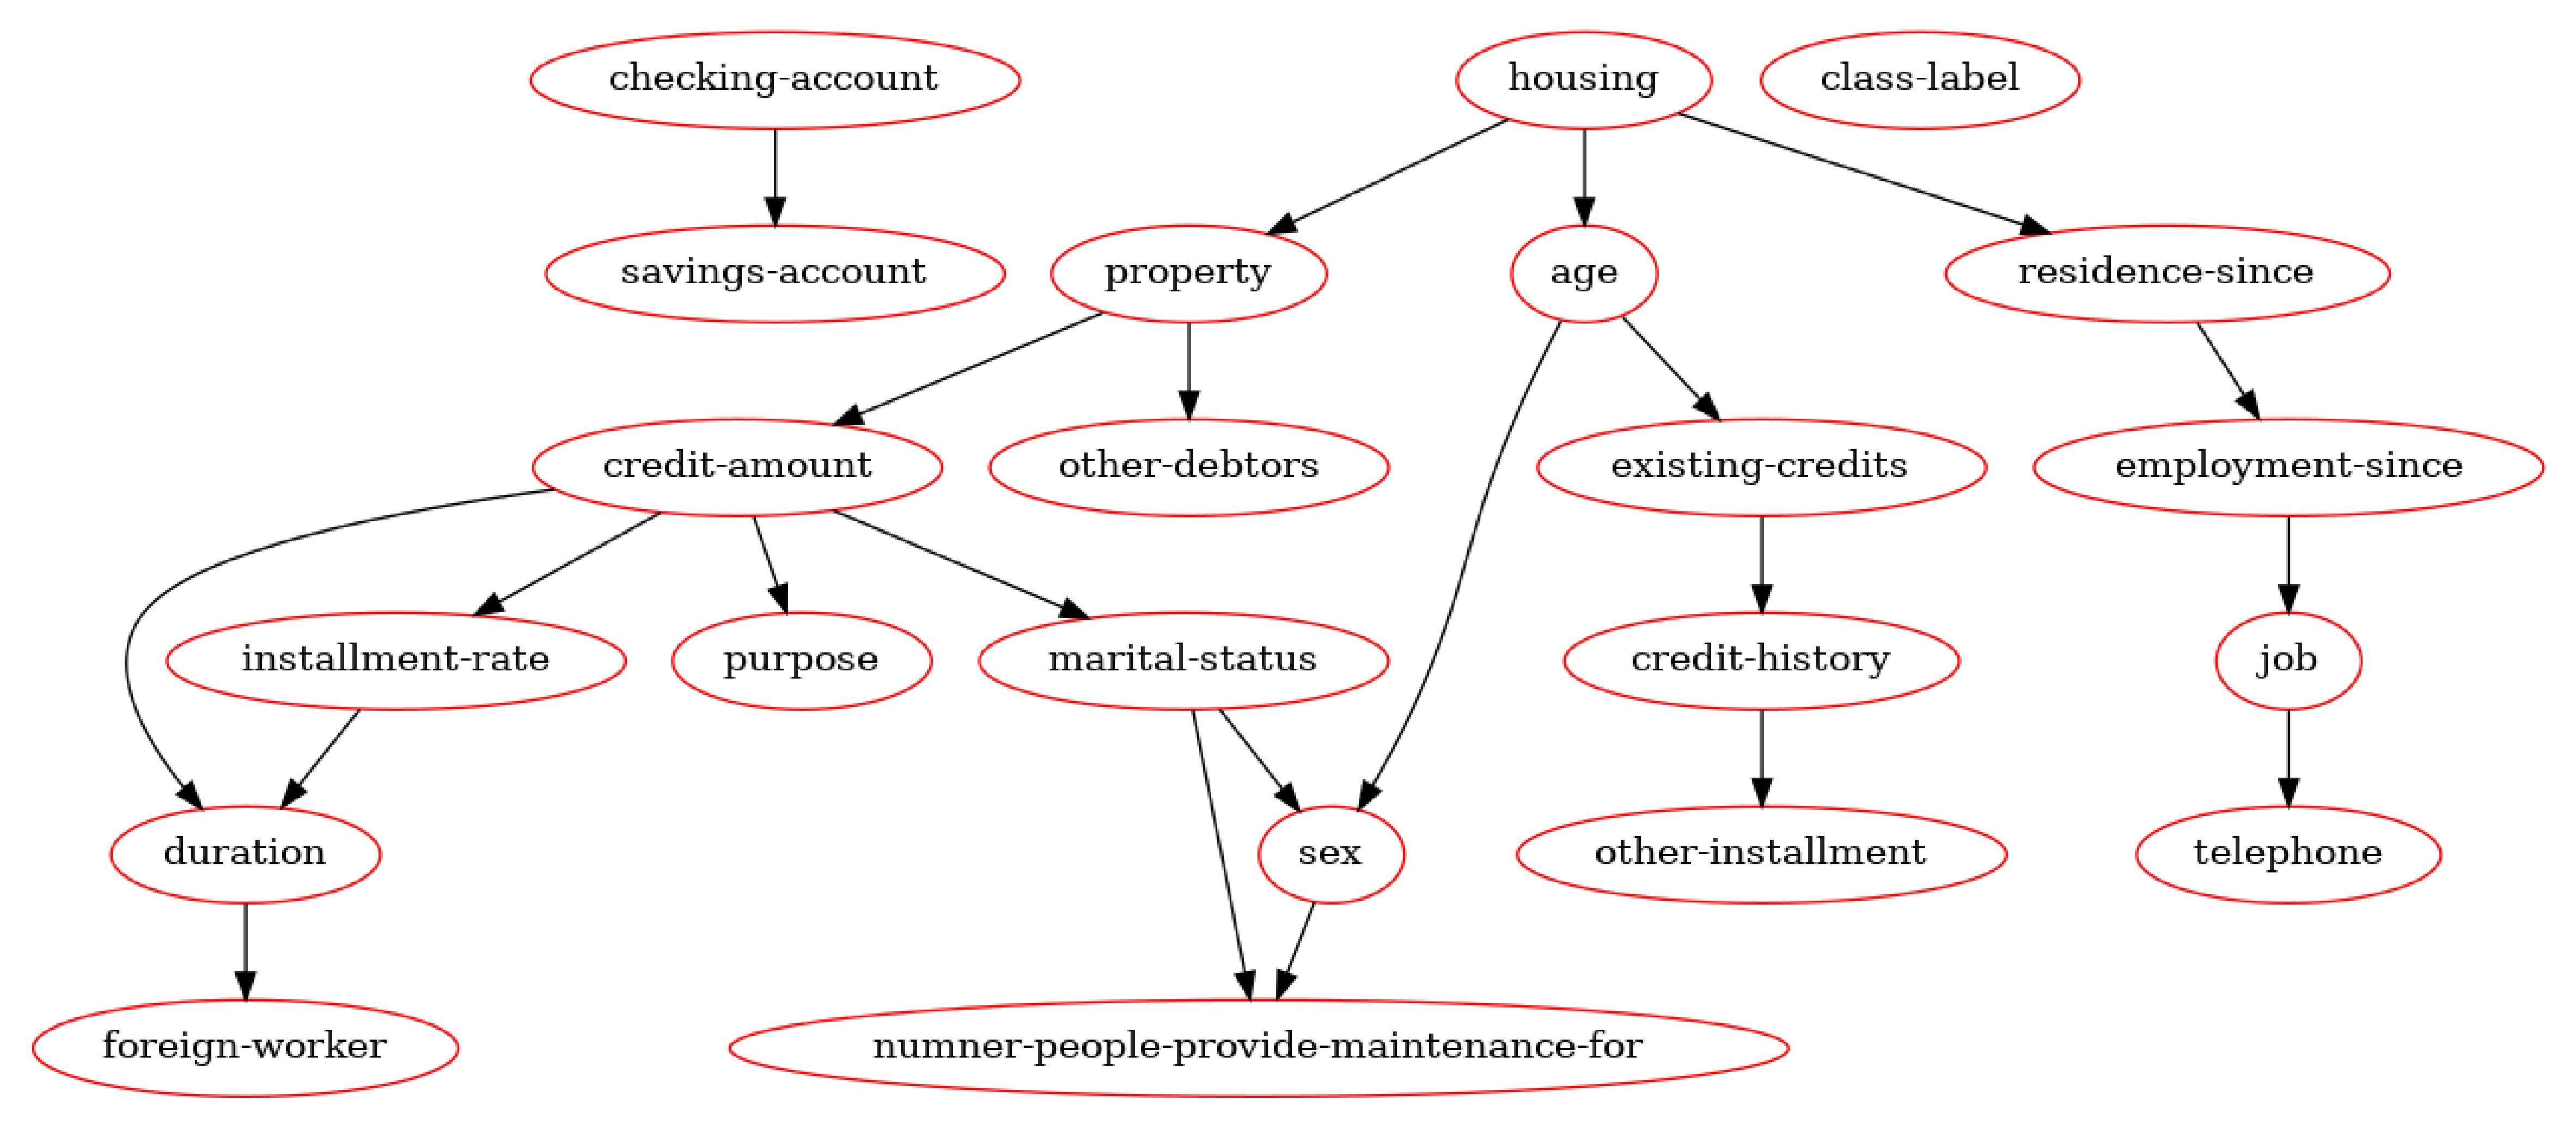

In [21]:
plt.figure(figsize=(15, 12),dpi=400)
model.plot()
plt.savefig('German.BN.pdf',bbox_inches='tight')

# 3. Data analysis

In [ ]:
import matplotlib.ticker as mtick
def plot_2_variable(dataset,var1, var2, width=0.5, wide=9,height=5,legend="", xlabel="", logy=False,verbose=True,indexlist="",index=False):
    
    var1_var2_ratio=round(pd.crosstab(dataset[var1], dataset[var2]).div(pd.crosstab(dataset[var1], dataset[var2]).apply(sum,1),0),3)*100
    var1_var2 =  pd.crosstab(dataset[var1], dataset[var2])
    if verbose:
        print(var1_var2)
        
    if index:
        var1_var2 = var1_var2.reindex(indexlist)
        var1_var2_ratio = var1_var2_ratio.reindex(indexlist)
    
    ax = var1_var2.plot(kind='bar',width=width,figsize=(wide,height)
                     ,logy=logy
                     )
    #x = hour_income_gender.plot(kind ='bar',stacked=False)
    xlocs, xlabs = plt.xticks()
    for i in range(len(var1_var2)):
        for j in range(len(var1_var2.iloc[i])):
            plt.text(xlocs[i]-0.35+j*0.3, var1_var2.iloc[i][j] + 2,str(round(var1_var2_ratio.iloc[i][j],1))+"%" )
    #plt.title('Distribution of '+ title+ ' across '+ legend)
    plt.ylabel('Population',fontsize=14,fontweight='bold')
    plt.xlabel(xlabel,fontsize=14,fontweight='bold')
    
    ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))
    plt.rc('xtick',labelsize=13)
    plt.rc('ytick',labelsize=13)
    plt.xticks(rotation=0)
    plt.legend(title=legend,prop={'size': 12})
    filename=var1+"_"+var2+".pdf"
    plt.savefig(filename,bbox_inches='tight')    
    

class-label  Bad  Good
sex                   
female       109   201
male         191   499


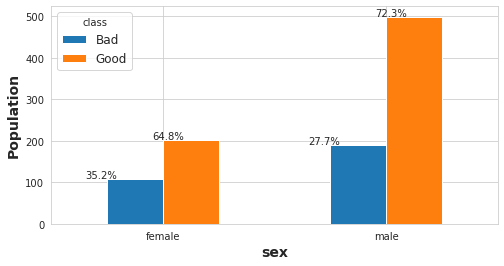

In [ ]:
#Sex vs class
plot_2_variable(df,var1='sex', var2='class-label', width=0.5, wide=8,height=4,
                legend="class", xlabel="sex", logy=False,verbose=True,indexlist="",index=False)

In [ ]:
pd.crosstab(df['sex'],df['class-label'])/len(df)

class-label,Bad,Good
sex,,
female,0.109,0.201
male,0.191,0.499


class-label  Bad  Good
age_enc               
0             80   110
1            220   590


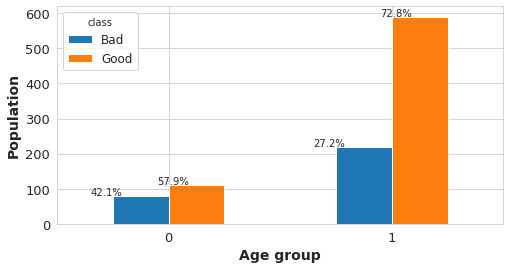

In [ ]:
#Age vs class
plot_2_variable(df,var1='age_enc', var2='class-label', width=0.5, wide=8,height=4,
                legend="class", xlabel="Age group", logy=False,verbose=True,indexlist="",index=False)

class-label       Bad  Good
checking-account           
0 <= <200 DM      105   164
<0 DM             135   139
>= 200 DM          14    49
no account         46   348


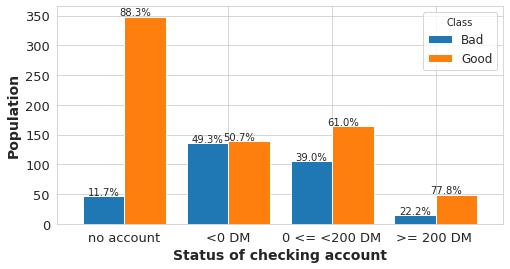

In [ ]:
plot_2_variable(df,var1='checking-account', var2='class-label', width=0.8, wide=8,height=4,
                legend="Class", xlabel="Status of checking account", logy=False,verbose=True,indexlist=["no account", "<0 DM","0 <= <200 DM",">= 200 DM "],index=True)

/home/tai/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='credit-amount'>

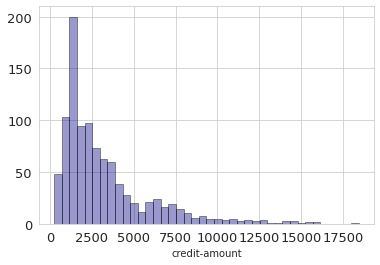

In [ ]:
#Credit amount
sns.distplot(df['credit-amount'], hist=True, kde=False, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

<AxesSubplot:xlabel='age'>

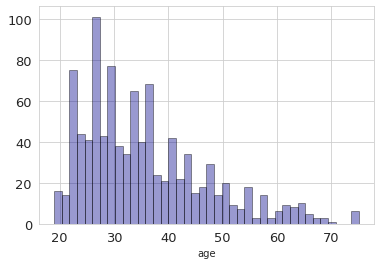

In [ ]:
#Age
sns.distplot(df['age'], hist=True, kde=False, 
             bins=40, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

<AxesSubplot:xlabel='duration'>

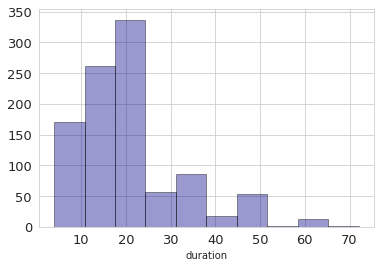

In [ ]:
#Duration
sns.distplot(df['duration'], hist=True, kde=False, 
             bins=10, color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

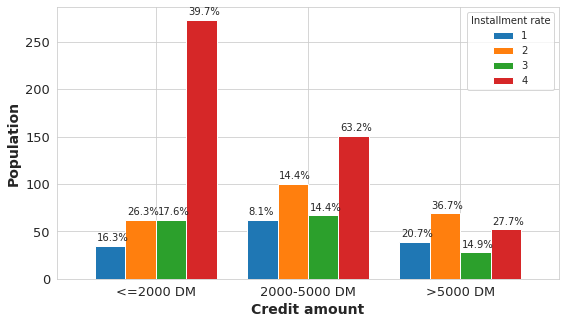

In [ ]:
#installment-rate and credit-amount
df['installment-rate']=df['installment-rate'].astype('category')
df['credit-amount_enc']=df['credit-amount_enc'].astype('category')

installment_credit_amount =  pd.crosstab(df['credit-amount_enc'], df['installment-rate'])
installment_credit_amount = installment_credit_amount.reindex(["<=2000 DM", "2000-5000 DM", ">5000 DM"])

installment_credit_amount_ratio = round(pd.crosstab(df['credit-amount_enc'], df['installment-rate']).div(pd.crosstab(df['credit-amount_enc'], df['installment-rate']).apply(sum,1),0),3)*100
                                                        
ax = installment_credit_amount.plot(kind='bar',logy=False,figsize=(9,5), width=0.8)

xlocs, xlabs = plt.xticks()
for i in range(len(installment_credit_amount)):
    for j in range(0,len(installment_credit_amount.iloc[i])):        
        plt.text(xlocs[i]-0.39+j*0.2, installment_credit_amount.iloc[i][j] + 5,str(round(installment_credit_amount_ratio.iloc[i][j],1))+"%" )

plt.ylabel('Population',fontsize=14,fontweight='bold')
plt.xlabel('Credit amount',fontsize=14,fontweight='bold')
#ax.yaxis.set_major_formatter(mtick.StrMethodFormatter('{x:,.0f}'))

plt.xticks(rotation=0)
plt.rc('xtick',labelsize=13)
plt.rc('ytick',labelsize=13)
plt.legend(title='Installment rate')
plt.savefig("German.installment_credit.pdf", bbox_inches='tight')